## Scenario 2: building a model trained on both stream gauges and HWMs

### a) Importing necessary libraries

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings 
import tensorflow as tf
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

### b) Reading the stream gauges and HWM data for hurricane Ida

In [4]:
# Read the CSV file into a pandas DataFrame
df_HWM = pd.read_csv('HWMs.csv', header=0)
df_HWM['Mean_Gage_height']= 0
df_HWM['Type'] = 'HWMs'

df_strm = pd.read_csv('Ida.csv', header=0)
df_strm['HAND']=0
df_strm['Distance to river']=0
df_strm['Flood']= df_strm['Max_Gage_height']-df_strm['Mean_Gage_height']
df_strm['Type'] = 'Stream'

### c) Combining stream gauge and HWM data

In [5]:
common_columns= [
    'Curvature',
    'Altitude', 
    'HAND', 
    'Storm surge', 
    'Wind speed', 
    'Rain',
    'Soil moisture', 
    'Flow accumulation', 
    'TWI', 
    'Slope',
    'Distance to river',
    'Distance to storm track', 
    'Mean_Gage_height',
    'Distance to sea',
    'Type',
    'Flood'   
]

# Select common columns from both DataFrames
df_HWM_common = df_HWM[common_columns]
df_strm_common = df_strm[common_columns]


# Concatenate DataFrames
df = pd.concat([df_HWM_common, df_strm_common], ignore_index=True)

# Save the DataFrame to a CSV file
df.to_csv('stream-hwm.csv', index=False)
df

,Curvature,Altitude,HAND,Storm surge,Wind speed,Rain,Soil moisture,Flow accumulation,TWI,Slope,Distance to river,Distance to storm track,Mean_Gage_height,Distance to sea,Type,Flood
0,-1.929120e+09,7.37162,8.89971,0.772498,34.5617,0.044960,0.392925,0,-5.933630,2.002040,0.000736,0.391555,0.000000,0.073790,HWMs,2.050000
1,-5.667340e+09,7.37162,8.74236,0.772498,34.5617,0.044960,0.392925,51,-2.421870,3.105190,0.000719,0.391619,0.000000,0.073833,HWMs,3.920000
2,-5.007710e+08,3.46794,3.46790,2.017150,33.5172,0.124228,0.331936,25,-0.200457,0.168553,0.015490,0.489294,0.000000,0.062434,HWMs,1.700000
3,1.010870e+09,3.74653,3.87530,1.589750,33.7572,0.119348,0.331936,0,-3.989910,0.286747,0.000391,0.419288,0.000000,0.133445,HWMs,2.300000
4,1.526490e+09,5.20485,5.68098,0.772498,34.5617,0.044960,0.392925,68759,6.244250,0.708235,0.000027,0.393270,0.000000,0.074235,HWMs,1.890000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,9.700830e+09,315.74000,0.00000,1.282130,31.5753,1.533940,0.279366,2592720,16.286273,12.305600,0.000000,0.985841,3.757292,0.370593,Stream,2.502708
367,3.441800e+08,270.50000,0.00000,1.296930,31.9977,1.286300,0.352202,2924290,18.546203,1.420260,0.000000,0.974283,2.472708,0.360568,Stream,5.177292
368,-1.934700e+09,331.84000,0.00000,1.275670,31.7314,1.619680,0.258539,552958,15.547339,5.531940,0.000000,0.916809,2.266146,0.303099,Stream,2.503854
369,-8.706530e+09,586.60000,0.00000,1.337360,30.7331,0.494721,0.381326,369281,14.192663,14.157900,0.000000,1.100598,1.503437,0.481995,Stream,2.766563


### d) Defining features and the target variable

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

features= [
    'Curvature',
    'Altitude', 
    'HAND', 
    'Storm surge', 
    'Wind speed', 
    'Rain',
    'Soil moisture', 
 #   'Flow accumulation', 
 #   'TWI', 
    'Slope',
    'Distance to river',
    'Distance to storm track', 
    'Mean_Gage_height',
    'Distance to sea' 
]
x = df[features].copy()


y = df['Flood']* 0.3048  #ft to m
x.shape

(371, 12)

### e) Splitting and scaling data

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = scaler.fit_transform(x)


# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.2, random_state=64)

### f) Creating a model 

In [11]:
# Define the input layer
inputs = tf.keras.Input(shape=(Xtrain.shape[1]))

# Define the hidden layers
hidden = tf.keras.layers.Dense(
    16, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(inputs)
hidden = tf.keras.layers.BatchNormalization()(hidden)
hidden = tf.keras.layers.Dense(
    32, activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(hidden)
hidden = tf.keras.layers.BatchNormalization()(hidden)
hidden = tf.keras.layers.Dense(
    16, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(hidden)
hidden = tf.keras.layers.BatchNormalization()(hidden)

# Define the output layer. Make sure the output dimension is correct.
outputs = tf.keras.layers.Dense(1, activation='relu')(hidden) # Ensures output is non-negative

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)


model.summary()


#Define the learning rate schedule
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=50,
    decay_rate=0.92,
    staircase=True
)

opt = tf.keras.optimizers.Adam(learning_rate=lr)


# Define a custom callback function
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] <0.12 and logs['loss']<0.12:
            self.model.stop_training = True

# Create an instance of the custom callback
custom_early_stopping = CustomEarlyStopping()


# Compile the model
model.compile(
    optimizer= opt, 
    loss='mean_absolute_error'
#    metrics=['accuracy']
)
model_checkpoint = ModelCheckpoint('model.h5', 
                                   monitor='val_loss', 
                                   save_best_only=True)
# Train your model
history = model.fit(
    Xtrain,
    Ytrain,
    batch_size=64,
    epochs=2000,
    validation_data=(Xtest, Ytest),
    callbacks=[custom_early_stopping, model_checkpoint]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 16)                208       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                528   

5/5 [==============================] - 0s 5ms/step - loss: 0.4169 - val_loss: 0.7475
Epoch 149/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.4091 - val_loss: 0.7778
Epoch 150/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.4120 - val_loss: 0.8030
Epoch 151/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3952 - val_loss: 0.8590
Epoch 152/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3917 - val_loss: 0.7902
Epoch 153/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.4028 - val_loss: 0.7582
Epoch 154/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3613 - val_loss: 0.7020
Epoch 155/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.3816 - val_loss: 0.6592
Epoch 156/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.3783 - val_loss: 0.6842
Epoch 157/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3993 - val_loss: 0.7598
Epoch 158/200

Epoch 230/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3571 - val_loss: 0.5330
Epoch 231/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3434 - val_loss: 0.4925
Epoch 232/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3288 - val_loss: 0.4717
Epoch 233/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3588 - val_loss: 0.4801
Epoch 234/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3330 - val_loss: 0.4838
Epoch 235/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.3680 - val_loss: 0.5774
Epoch 236/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3206 - val_loss: 0.6074
Epoch 237/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3379 - val_loss: 0.5782
Epoch 238/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3426 - val_loss: 0.5280
Epoch 239/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3654 - val_loss: 0.4880


Epoch 312/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3091 - val_loss: 0.4586
Epoch 313/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.3132 - val_loss: 0.4456
Epoch 314/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3176 - val_loss: 0.4431
Epoch 315/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3058 - val_loss: 0.4523
Epoch 316/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3214 - val_loss: 0.4682
Epoch 317/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.3103 - val_loss: 0.4614
Epoch 318/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3250 - val_loss: 0.4546
Epoch 319/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3304 - val_loss: 0.4658
Epoch 320/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2856 - val_loss: 0.4767
Epoch 321/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3171 - val_loss: 0.4643


Epoch 394/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2903 - val_loss: 0.4335
Epoch 395/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2943 - val_loss: 0.4319
Epoch 396/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2757 - val_loss: 0.4361
Epoch 397/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.3129 - val_loss: 0.4402
Epoch 398/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3110 - val_loss: 0.4355
Epoch 399/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2892 - val_loss: 0.4365
Epoch 400/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2750 - val_loss: 0.4449
Epoch 401/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2988 - val_loss: 0.4395
Epoch 402/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2915 - val_loss: 0.4415
Epoch 403/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2844 - val_loss: 0.4377


Epoch 476/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2780 - val_loss: 0.4253
Epoch 477/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3141 - val_loss: 0.4202
Epoch 478/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2884 - val_loss: 0.4219
Epoch 479/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.3179 - val_loss: 0.4239
Epoch 480/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2831 - val_loss: 0.4234
Epoch 481/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2845 - val_loss: 0.4192
Epoch 482/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2718 - val_loss: 0.4171
Epoch 483/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2783 - val_loss: 0.4210
Epoch 484/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3042 - val_loss: 0.4179
Epoch 485/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2849 - val_loss: 0.4142


Epoch 558/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2715 - val_loss: 0.4154
Epoch 559/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2683 - val_loss: 0.4187
Epoch 560/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2839 - val_loss: 0.4204
Epoch 561/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2793 - val_loss: 0.4235
Epoch 562/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2945 - val_loss: 0.4267
Epoch 563/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2955 - val_loss: 0.4277
Epoch 564/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3337 - val_loss: 0.4268
Epoch 565/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2873 - val_loss: 0.4252
Epoch 566/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2940 - val_loss: 0.4262
Epoch 567/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2900 - val_loss: 0.4265


Epoch 640/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.2757 - val_loss: 0.4167
Epoch 641/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2760 - val_loss: 0.4174
Epoch 642/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.2804 - val_loss: 0.4170
Epoch 643/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2433 - val_loss: 0.4163
Epoch 644/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2688 - val_loss: 0.4160
Epoch 645/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3001 - val_loss: 0.4160
Epoch 646/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2804 - val_loss: 0.4155
Epoch 647/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2845 - val_loss: 0.4168
Epoch 648/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2671 - val_loss: 0.4178
Epoch 649/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2520 - val_loss: 0.4185


Epoch 722/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2939 - val_loss: 0.4145
Epoch 723/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2914 - val_loss: 0.4149
Epoch 724/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3422 - val_loss: 0.4145
Epoch 725/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2772 - val_loss: 0.4145
Epoch 726/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3063 - val_loss: 0.4144
Epoch 727/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2982 - val_loss: 0.4146
Epoch 728/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2651 - val_loss: 0.4145
Epoch 729/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2842 - val_loss: 0.4146
Epoch 730/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2965 - val_loss: 0.4156
Epoch 731/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2884 - val_loss: 0.4158


Epoch 804/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2737 - val_loss: 0.4117
Epoch 805/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2858 - val_loss: 0.4118
Epoch 806/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2797 - val_loss: 0.4121
Epoch 807/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2591 - val_loss: 0.4124
Epoch 808/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2610 - val_loss: 0.4122
Epoch 809/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2625 - val_loss: 0.4125
Epoch 810/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2697 - val_loss: 0.4127
Epoch 811/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2859 - val_loss: 0.4127
Epoch 812/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2756 - val_loss: 0.4126
Epoch 813/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3098 - val_loss: 0.4126


Epoch 886/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2811 - val_loss: 0.4128
Epoch 887/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3058 - val_loss: 0.4126
Epoch 888/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3220 - val_loss: 0.4128
Epoch 889/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2654 - val_loss: 0.4130
Epoch 890/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2532 - val_loss: 0.4131
Epoch 891/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2991 - val_loss: 0.4130
Epoch 892/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2832 - val_loss: 0.4130
Epoch 893/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2477 - val_loss: 0.4134
Epoch 894/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2901 - val_loss: 0.4131
Epoch 895/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2686 - val_loss: 0.4131


Epoch 968/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2716 - val_loss: 0.4121
Epoch 969/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2728 - val_loss: 0.4121
Epoch 970/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2749 - val_loss: 0.4121
Epoch 971/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2828 - val_loss: 0.4121
Epoch 972/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2544 - val_loss: 0.4125
Epoch 973/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2745 - val_loss: 0.4123
Epoch 974/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2823 - val_loss: 0.4123
Epoch 975/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.3316 - val_loss: 0.4122
Epoch 976/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2574 - val_loss: 0.4120
Epoch 977/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2488 - val_loss: 0.4122


5/5 [==============================] - 0s 6ms/step - loss: 0.2718 - val_loss: 0.4119
Epoch 1131/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2997 - val_loss: 0.4119
Epoch 1132/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2755 - val_loss: 0.4119
Epoch 1133/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2976 - val_loss: 0.4121
Epoch 1134/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2933 - val_loss: 0.4124
Epoch 1135/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2748 - val_loss: 0.4125
Epoch 1136/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2736 - val_loss: 0.4128
Epoch 1137/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2755 - val_loss: 0.4126
Epoch 1138/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3080 - val_loss: 0.4125
Epoch 1139/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2528 - val_loss: 0.4124
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.2672 - val_loss: 0.4124
Epoch 1293/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2797 - val_loss: 0.4123
Epoch 1294/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2789 - val_loss: 0.4123
Epoch 1295/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3100 - val_loss: 0.4125
Epoch 1296/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2530 - val_loss: 0.4125
Epoch 1297/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2908 - val_loss: 0.4129
Epoch 1298/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3161 - val_loss: 0.4134
Epoch 1299/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2867 - val_loss: 0.4136
Epoch 1300/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2701 - val_loss: 0.4135
Epoch 1301/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3053 - val_loss: 0.4132
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.3166 - val_loss: 0.4118
Epoch 1455/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2760 - val_loss: 0.4117
Epoch 1456/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2891 - val_loss: 0.4118
Epoch 1457/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2763 - val_loss: 0.4118
Epoch 1458/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2592 - val_loss: 0.4117
Epoch 1459/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2886 - val_loss: 0.4116
Epoch 1460/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2882 - val_loss: 0.4117
Epoch 1461/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2569 - val_loss: 0.4118
Epoch 1462/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.3102 - val_loss: 0.4117
Epoch 1463/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2647 - val_loss: 0.4117
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.3198 - val_loss: 0.4109
Epoch 1617/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2882 - val_loss: 0.4112
Epoch 1618/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.3146 - val_loss: 0.4114
Epoch 1619/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2727 - val_loss: 0.4116
Epoch 1620/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2912 - val_loss: 0.4119
Epoch 1621/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2943 - val_loss: 0.4117
Epoch 1622/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2615 - val_loss: 0.4120
Epoch 1623/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2653 - val_loss: 0.4119
Epoch 1624/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2951 - val_loss: 0.4121
Epoch 1625/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2785 - val_loss: 0.4123
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.2508 - val_loss: 0.4120
Epoch 1779/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3045 - val_loss: 0.4121
Epoch 1780/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2774 - val_loss: 0.4123
Epoch 1781/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2650 - val_loss: 0.4121
Epoch 1782/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2414 - val_loss: 0.4120
Epoch 1783/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2697 - val_loss: 0.4120
Epoch 1784/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2318 - val_loss: 0.4121
Epoch 1785/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.2611 - val_loss: 0.4124
Epoch 1786/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2785 - val_loss: 0.4123
Epoch 1787/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2888 - val_loss: 0.4122
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.2856 - val_loss: 0.4116
Epoch 1941/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2936 - val_loss: 0.4117
Epoch 1942/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.3104 - val_loss: 0.4117
Epoch 1943/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2421 - val_loss: 0.4120
Epoch 1944/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.2976 - val_loss: 0.4118
Epoch 1945/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.2601 - val_loss: 0.4119
Epoch 1946/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2353 - val_loss: 0.4120
Epoch 1947/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2636 - val_loss: 0.4119
Epoch 1948/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.2663 - val_loss: 0.4121
Epoch 1949/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2725 - val_loss: 0.4122
Epoch 

### Evaluating model performance on both the training and test data.

In [9]:
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

# Evaluate the model on the test set
Ytrain_pred = model.predict(Xtrain)
Ytest_pred = model.predict(Xtest)


print("R-squared for train: {:.2f}".format(r2_score(Ytrain, Ytrain_pred)))
print("R-squared for test: {:.2f}".format(r2_score(Ytest, Ytest_pred)))
print("MAE for train: {:.2f}".format(metrics.mean_absolute_error(Ytrain, Ytrain_pred)))
print("MAE for test: {:.2f}".format(metrics.mean_absolute_error(Ytest, Ytest_pred)))
print("Median Absolute Error for train: {:.2f}".format(median_absolute_error(Ytrain, Ytrain_pred)))
print("Median Absolute Error for test: {:.2f}".format(median_absolute_error(Ytest, Ytest_pred)))
print("Normalized Root Mean Square Error for train: {:.2f}".format(np.sqrt(mean_squared_error(Ytrain, Ytrain_pred))*100 / (np.mean(Ytrain))))
print("Normalized Root Mean Square Error for test: {:.2f}".format(np.sqrt(mean_squared_error(Ytest, Ytest_pred))*100 / (np.mean(Ytest))))

3/3 [==============================] - 0s 2ms/step
R-squared for train: 0.93
R-squared for test: 0.84
MAE for train: 0.16
MAE for test: 0.38
Median Absolute Error for train: 0.08
Median Absolute Error for test: 0.29
Normalized Root Mean Square Error for train: 29.95
Normalized Root Mean Square Error for test: 56.43


### Saving the model

In [19]:
# Specify the path and filename for the model
model_path = 'Scenario2.h5'

# Use the .save() method to save your model
model.save(model_path)

print(f"Model saved to {model_path}")


Model saved to Scenario2.h5


### Scatter plots

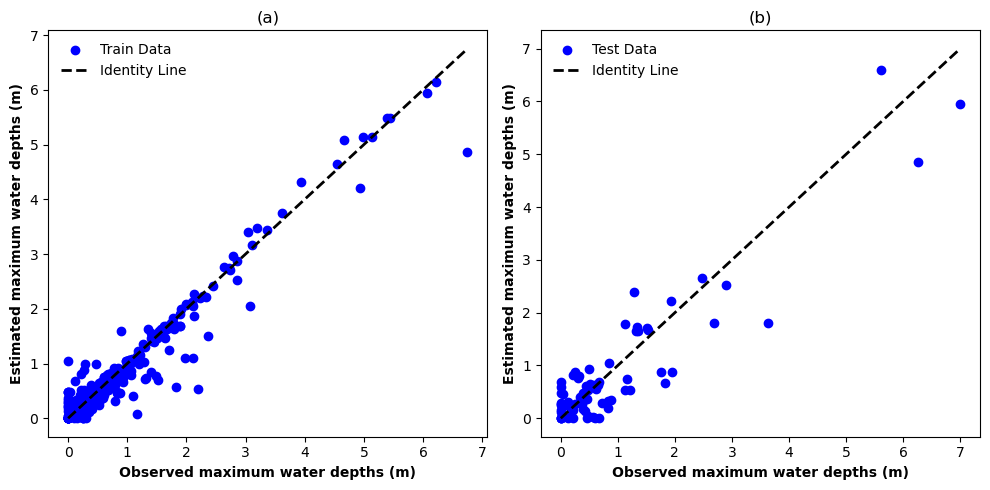

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Scatter plot for simulated vs observed max flood depths (Train Data)
axes[0].scatter(Ytrain, Ytrain_pred, color='blue', label='Train Data')
axes[0].plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=2, label='Identity Line')
axes[0].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[0].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[0].set_title('(a)')
axes[0].legend(frameon=False)  # No legend box

# Scatter plot for simulated vs observed max flood depths (Test Data)
axes[1].scatter(Ytest, Ytest_pred, color='blue', label='Test Data')
axes[1].plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], 'k--', lw=2, label='Identity Line')
axes[1].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[1].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[1].set_title('(b)')
axes[1].legend(frameon=False)  # No legend box

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Evaluating stream gauges, HWMs, and stream gagues + HWMs

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error

def evaluate_model(predictions, actuals, model_name):
    # Flatten predictions if necessary
    predictions = predictions
    
    # Calculate metrics
    r_squared = np.round(r2_score(actuals, predictions), 2)
    mae = mean_absolute_error(actuals, predictions)
    mdae = median_absolute_error(actuals, predictions)
    nrmse = np.sqrt(mean_squared_error(actuals, predictions)) * 100 / np.mean(actuals)
    bias = np.mean(predictions - actuals)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    # Prepare DataFrame
    errors_df = pd.DataFrame({
        "Metric": ["R-squared", "MAE", "Median Absolute Error", "NRMSE", "BIAS", "RMSE"],
        "Value": [r_squared, mae, mdae, nrmse, bias, rmse]
    })
    
    # Print the DataFrame to check
    print(f"Errors for {model_name}:")
    print(errors_df)

    # Save to CSV
    errors_df.to_csv(f"errors_{model_name}.csv", index=False)

    return errors_df


In [12]:
# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_t = df['Flood'] * 0.3048 

# Ensure 'features' contains the correct column names you want to use for the model
x_t = df[features].copy()

# Scale the data
x_t_scaled = scaler.fit_transform(x_t)

# Assuming 'best_model' is already trained and ready to be used for predictions
y_t_pred = model.predict(x_t_scaled).flatten()


errors_df_t = evaluate_model(y_t_pred, y_t, "Overall_S2")


# First, add y_t and y_t_pred to your DataFrame if they aren't already included
df['y_t'] = y_t
df['y_t_pred'] = y_t_pred



# Correct filtering of the DataFrame based on 'Type'
df_strm = df[df['Type'] == 'Stream']

# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_strm = df_strm['y_t']  
y_strm_pred = df_strm['y_t_pred'] 

errors_df_strm = evaluate_model(y_strm_pred, y_strm, "Stream_S2")


# Correct filtering of the DataFrame based on 'Type'
df_HWM = df[df['Type'] == 'HWMs']

# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_HWM = df_HWM['y_t']  
y_HWM_pred = df_HWM['y_t_pred'] 

errors_df_HWM = evaluate_model(y_HWM_pred, y_HWM, "HWMs_S2")

12/12 [==============================] - 0s 1ms/step
Errors for Overall_S2:
                  Metric      Value
0              R-squared   0.910000
1                    MAE   0.205335
2  Median Absolute Error   0.097246
3                  NRMSE  36.388751
4                   BIAS  -0.035501
5                   RMSE   0.352105
Errors for Stream_S2:
                  Metric      Value
0              R-squared   0.920000
1                    MAE   0.242144
2  Median Absolute Error   0.078918
3                  NRMSE  22.596293
4                   BIAS  -0.070590
5                   RMSE   0.443617
Errors for HWMs_S2:
                  Metric      Value
0              R-squared   0.600000
1                    MAE   0.188591
2  Median Absolute Error   0.104417
3                  NRMSE  58.559995
4                   BIAS  -0.019538
5                   RMSE   0.301419
